## 04 대표적인 비지도 학습법
* 지도학습과 비지도학습

## 학습 내용
### 01. Autoencoder란?
### 02. 간단한 예제를 보자.
### 03. 어디에 사용되는가?
<hr>

## 01. Autoencoder란?

### 대표적인 비지도학습으로 많이 쓰이는 신경망 오토인코더(Autoencoder)가 있다.
### 오토 인코더는 <font style="color:blue">입력값과 출력값을 같게</font> 하는 신경망이다.
 * 훈련 데이터와 매우 비슷한 새로운 데이터를 생성한다.
 * 만약 얼굴 사진을 이용하여 오토 인코더를 훈련시키면 이 모델은 새로운 얼굴을 생성할 수 있다.
 * 출력층의 뉴런수와 입력수가 동일하다는 것을 제외하면 일반적으로 오토 인코더는 다층 퍼셉트론과 동일한 구조를 갖는다.
 
### 인코더와 디코더로 구성
 * 입력을 내부 표현을 변경하는 인코더(encoder)
 * 내부 표현을 출력으로 바꾸는 디코더(decoder)

### <font style="color:blue">가운데 계층의 노드 수가 입력값보다 적은 것</font>이 특징이다.
### 결과적으로 입력 데이터를 압축하는 효과를 얻는다. 이 과정이 <font style="color:blue">노이즈 제거에 많이 효과적</font>이다.
### <font style="color:blue">변이형 오토인코더(Variational Autoencoder), 잡음제거 오토 인코더(Denoising Autoencoder)</font> 등의 방식이 존재

<img src="../img/autoencoder01.png">

## 메모(알아두기) :
 *  (01) 입력층으로 들어온 데이터를 인코더를 통해 은닉층으로 내보낸다.
 *  (02) 은닉층의 데이터를 디코더를 통해 출력층으로 내보낸다.
 *  (03) 만들어진 출력값과 입력값이 같아지도록 만드는 가중치를 찾아낸다.

## 02. 간단한 예제를 보자.

In [1]:
import os, warnings
# warnings.filterwarnings(action='default')
warnings.filterwarnings(action='ignore')

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./mnist/data/", one_hot=True)

Extracting ./mnist/data/train-images-idx3-ubyte.gz
Extracting ./mnist/data/train-labels-idx1-ubyte.gz
Extracting ./mnist/data/t10k-images-idx3-ubyte.gz
Extracting ./mnist/data/t10k-labels-idx1-ubyte.gz


In [6]:
learning_rate = 0.01    # 학습율 0.01
training_epoch = 20     # 훈련 전체 데이터 사용 횟수 20회 
batch_size = 100        # 배치 사이즈 100
n_hidden = 256          # 은닉층의 노드 개수 256
n_input = 28 * 28       # 784개 (입력층) 

### 오토 인코더의 핵심
* 인코더와 디코더를 만들기

### 인코더(encoder) 만들기 
 * STEP 01. 맨처음은 n_hidden개의 뉴런을 가지는 은닉층을 만들기
 * STEP 02. 가중치(W)와 편향 변수(B)를 원하는 뉴런의 개수만큼 설정.
 * STEP 03. 활성화 함수 sigmoid 함수를 적용.
 * 기억해두기, <font style="color:blue">n_input(입력층 노드) 값보다 n_hidden(은닉층 노드) 값이 더 작다.</font>
    * 항상 그런것이 아니라 은닉층이 더 큰 오토인코더 모델도 있음.

In [8]:
X = tf.placeholder(tf.float32, [None, n_input])
W_encode = tf.Variable(tf.random_normal([n_input, n_hidden])) # W의 지정
b_encode = tf.Variable(tf.random_normal([n_hidden]))          # 

encoder = tf.nn.sigmoid(tf.add(tf.matmul(X, W_encode), b_encode)) # 

### 디코더(decoder) 만들기 
* Tip01. 여기서 입력값은 은닉층의 노드수가 된다.
* Tip02. 출력값을 입력층의 크기로 만듬.
<hr>
* 은닉층 데이터를 디코더를 통해 출력층으로 내보낸다.
* 만들어진 출력값을 입력값과 비슷해 지도록 만드는 가중치를 찾는다.

In [9]:
W_decode = tf.Variable(tf.random_normal([n_hidden, n_input]))
b_decode = tf.Variable(tf.random_normal([n_input]))
decoder = tf.nn.sigmoid(tf.add(tf.matmul(encoder, W_decode), b_decode))

### <font style="color:red">오토 인코더의 최종 목적은 출력값과 입력값을 가장 비슷하게 만드는 것</font>
* 이렇게 될 경우, 은닉층의 뉴런들을 통해 입력값의 특징을 알 수 있음.

### 손실함수(cost) 및 최적화(optimizer)함수
* 입력값 X를 평가하기 위한 실측값 사용.
* 디코더가 내보낸 결과값과의 차이(X-decoder)를 손실값으로 설정.

In [10]:
cost = tf.reduce_mean(tf.pow(X- decoder, 2))

### 최적함 함수 사용 : RMSPropOptimizer 함수

In [11]:
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

### 학습 진행
* 세션 설정
* 배치 사이즈 지정
* 학습 수행

In [12]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

total_batch = int(mnist.train.num_examples/batch_size)

for epoch in range(training_epoch):
    total_cost = 0
    
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        _, cost_val = sess.run([optimizer, cost], 
                              feed_dict={X:batch_xs})
        total_cost += cost_val
        
    print('Epoch:', '%04d' % (epoch + 1), 
         'Avg. cost=', '{:.4f}'.format(total_cost / total_batch))
    
print('최적화 완료!')

Epoch: 0001 Avg. cost= 0.1978
Epoch: 0002 Avg. cost= 0.0516
Epoch: 0003 Avg. cost= 0.0408
Epoch: 0004 Avg. cost= 0.0368
Epoch: 0005 Avg. cost= 0.0346
Epoch: 0006 Avg. cost= 0.0328
Epoch: 0007 Avg. cost= 0.0317
Epoch: 0008 Avg. cost= 0.0311
Epoch: 0009 Avg. cost= 0.0303
Epoch: 0010 Avg. cost= 0.0293
Epoch: 0011 Avg. cost= 0.0280
Epoch: 0012 Avg. cost= 0.0274
Epoch: 0013 Avg. cost= 0.0270
Epoch: 0014 Avg. cost= 0.0267
Epoch: 0015 Avg. cost= 0.0262
Epoch: 0016 Avg. cost= 0.0250
Epoch: 0017 Avg. cost= 0.0248
Epoch: 0018 Avg. cost= 0.0247
Epoch: 0019 Avg. cost= 0.0245
Epoch: 0020 Avg. cost= 0.0244
최적화 완료!


### 디코더로 생성해 낸 결과를 직관적 방법으로 확인

In [13]:
sample_size = 10
samples = sess.run(decoder, 
                  feed_dict = {X:mnist.test.images[:sample_size]})
samples

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 5.2657723e-04, ..., 0.0000000e+00,
        7.9498589e-03, 0.0000000e+00],
       [2.9802322e-08, 2.3841858e-06, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 2.9802322e-08, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [7.0333481e-06, 0.0000000e+00, 1.7881393e-07, ..., 0.0000000e+00,
        1.7881393e-07, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 2.9802322e-08]], dtype=float32)

### 위쪽 이미지가 원본, 아래쪽이 신경망(오토인코더)가 생성.

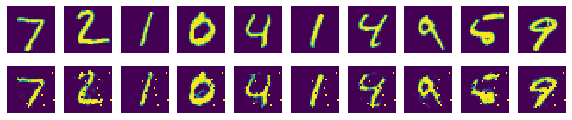

In [14]:
fig, ax = plt.subplots(2, sample_size, figsize=(sample_size, 2))

for i in range(sample_size):
    ax[0][i].set_axis_off()
    ax[1][i].set_axis_off()
    ax[0][i].imshow(np.reshape(mnist.test.images[i], (28,28)))
    ax[1][i].imshow(np.reshape(samples[i], (28,28)))
    
plt.show()

## 03. 어디에 사용되는가?

### 암호화, 비정상 거래 검출 등.